## This notebook will be used for the Coursera Capstone course for Applied Data Science By IBM

### <ins>Imports needed for this notebook</ins>

In [33]:
import pandas as pd 
import numpy as np 
#!conda install -c conda-forge folium=0.5.0 --yes
import folium # plotting library
from sklearn.cluster import KMeans
import matplotlib.cm as cm
import matplotlib.colors as colors
import warnings
warnings.filterwarnings("ignore")

##### <ins>Read the file from html using pandas</ins>

In [13]:
data=pd.read_html('https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M')[0]

##### Find and eliminate the "Not Assigned" Boroughs
##### Where Neighborhood is not assigned replace with the Borough

In [14]:
Toronto_Data=data[data['Borough']!="Not assigned"]
Toronto_Data['Neighbourhood'] = np.where(Toronto_Data['Neighbourhood'] == 'Not assigned',Toronto_Data['Borough'], Toronto_Data['Neighbourhood'])
Toronto_Data.head(11)

,Postal Code,Borough,Neighbourhood
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,"Regent Park, Harbourfront"
5,M6A,North York,"Lawrence Manor, Lawrence Heights"
6,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government"
8,M9A,Etobicoke,"Islington Avenue, Humber Valley Village"
9,M1B,Scarborough,"Malvern, Rouge"
11,M3B,North York,Don Mills
12,M4B,East York,"Parkview Hill, Woodbine Gardens"
13,M5B,Downtown Toronto,"Garden District, Ryerson"


##### <ins>Shape of the Data</ins>

In [15]:
Toronto_Data.shape

(103, 3)

##### <ins>Read in data for coordinates then merge them into the dataframe</ins>

In [16]:
GEO=pd.read_csv('Geospatial_Coordinates.csv')

In [17]:
Toronto_Data=Toronto_Data.merge(GEO,on='Postal Code')

In [18]:
Toronto_Data

,Postal Code,Borough,Neighbourhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.753259,-79.329656
1,M4A,North York,Victoria Village,43.725882,-79.315572
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494
...,...,...,...,...,...
98,M8X,Etobicoke,"The Kingsway, Montgomery Road, Old Mill North",43.653654,-79.506944
99,M4Y,Downtown Toronto,Church and Wellesley,43.665860,-79.383160
100,M7Y,East Toronto,"Business reply mail Processing Centre, South C...",43.662744,-79.321558
101,M8Y,Etobicoke,"Old Mill South, King's Mill Park, Sunnylea, Hu...",43.636258,-79.498509


##### <ins>Use metrics and cdist to come up with plots to show a viable number of centrioids needed for kmeans clustering</ins>

In [26]:
from sklearn import metrics 
from scipy.spatial.distance import cdist 

distortions = [] 
inertias = [] 
mapping1 = {} 
mapping2 = {} 
K = range(1,10) 
  
for k in K:  
    kmeanModel = KMeans(n_clusters=k).fit(Toronto_Data[['Longitude','Latitude']]) 
    kmeanModel.fit(Toronto_Data[['Longitude','Latitude']])     
      
    distortions.append(sum(np.min(cdist(Toronto_Data[['Longitude','Latitude']], kmeanModel.cluster_centers_, 
                      'euclidean'),axis=1)) / Toronto_Data[['Longitude','Latitude']].shape[0]) 
    inertias.append(kmeanModel.inertia_) 
  
    mapping1[k] = sum(np.min(cdist(Toronto_Data[['Longitude','Latitude']], kmeanModel.cluster_centers_, 
                 'euclidean'),axis=1)) / Toronto_Data[['Longitude','Latitude']].shape[0] 
    mapping2[k] = kmeanModel.inertia_ 

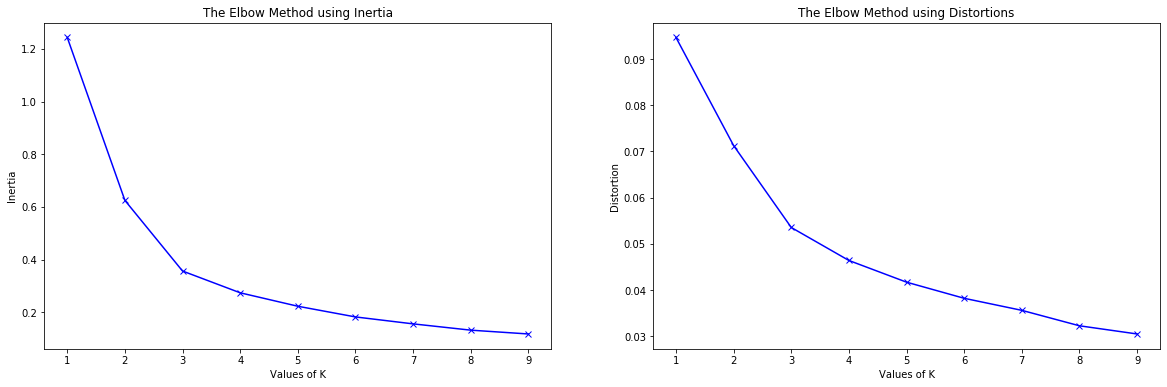

In [100]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(20,6))
ax1.plot(K, inertias, 'bx-') 
ax1.set_xlabel('Values of K') 
ax1.set_ylabel('Inertia') 
ax1.set_title('The Elbow Method using Inertia') 
 
ax2.plot(K, distortions, 'bx-') 
ax2.set_xlabel('Values of K') 
ax2.set_ylabel('Distortion') 
ax2.set_title('The Elbow Method using Distortions') 
plt.show() 

#### In both graphs it appears as though there are large decreases leading up to the number three. Visually 3 may be the best option for kmeans clustering. Lets try 4 also.

##### <ins>Kmeans cluster creation with 3 clusters</ins>

In [103]:
km=KMeans(n_clusters=3,max_iter=1000)
km.fit(Toronto_Data[['Longitude','Latitude']])
Toronto_Data['Cluster']=km.predict(Toronto_Data[['Longitude','Latitude']])

In [104]:
longitude=-79.3832
latitude=43.6532
kclusters=3
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=10)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.gist_ncar(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(Toronto_Data['Latitude'], Toronto_Data['Longitude'],Toronto_Data['Neighbourhood'],Toronto_Data['Cluster']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=3,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

###### Graph created shows 3 clusters of Toronto Neighborhoods. It appears as though there could be one more distinct one at the bottom where most of the points are clustered. Lets try 4 to see if it sections off that bottom middle area. 

In [105]:
km=KMeans(n_clusters=4,max_iter=1000)
km.fit(Toronto_Data[['Longitude','Latitude']])
Toronto_Data['Cluster']=km.predict(Toronto_Data[['Longitude','Latitude']])

In [106]:
longitude=-79.3832
latitude=43.6532
kclusters=4
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=10)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.gist_ncar(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(Toronto_Data['Latitude'], Toronto_Data['Longitude'],Toronto_Data['Neighbourhood'],Toronto_Data['Cluster']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=3,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

###### It looks as though the bottom middle section has it's own neighborhood. This one looks more visually correct. 